# Strojové učenie

# Zdroje
[Encoding] - https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931

[Stromy] - http://scikit-learn.org/stable/modules/tree.html

# Knižnice

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

import pydotplus
import collections

import category_encoders as ce

In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
#Normalizujeme si kategoricke atributy na cisla
def encodeByNum(data):
    metadata = data.drop(['CLASS'], axis=1)
    columns = metadata.select_dtypes('object').columns
    metadata = pd.get_dummies(metadata, prefix=columns)
    metadata['CLASS'] = data['CLASS']
    return metadata

In [4]:
def init_dataset(file):
    # Načítame si súbor s datasetom so separátom ',' a ako index nastavime prvý stĺpec
    data = pd.read_csv(file, sep='\t', index_col=0)
    
    metadata = data.drop(['DATE_OF_BIRTH', 'CLASS'], axis=1)
    col_names = metadata.select_dtypes('object').columns
    metadata['CLASS'] = data['CLASS']
    
    print(metadata.info())
    return metadata

# Doplnkové čistenie
- V tejto časti opisujeme doplnkove cistenie dat na zaklade revizie predchadzajuceho odovzdania

## Doplnenie chybajucich hodnot v testovacich datach podla trenovacich dat

## Transformacia kategorickych na numerické

In [7]:
#Inicializacia datasetu so zjednotenými nazvami
test_file = "data/zadanie4/ctest_revision.csv"
train_file = "data/zadanie4/ctrain.csv"

train_data = init_dataset(train_file)
test_data = init_dataset(test_file)

#Ziskame si pocet trenovacich dat, aby sme vedeli podla, ktoreho indexu ich neskôr rozdelime
train_rows_count = train_data.shape[0]

data = pd.concat([train_data, test_data])
data.reset_index(drop=True)

#Transformacia kategorickych na numericke
data = encodeByNum(data)

#Rozdelenie dat naspat na vstupne datsety
train_data = data.loc[:train_rows_count+1,:]
test_data = data.loc[train_rows_count:,:]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2798 entries, 0 to 2799
Data columns (total 39 columns):
AGE                          2798 non-null float64
SEX                          2798 non-null float64
ON_THYROXINE                 2798 non-null bool
QUERY_ON_THYROXINE           2798 non-null bool
ON_ANTITHYROID_MEDICATION    2798 non-null bool
SICK                         2798 non-null bool
PREGNANT                     2798 non-null bool
THYROID_SURGERY              2798 non-null bool
I131_TREATMENT               2798 non-null bool
QUERY_HYPOTHYROID            2798 non-null bool
QUERY_HYPERTHYROID           2798 non-null bool
LITHIUM                      2798 non-null bool
GOITRE                       2798 non-null bool
TUMOR                        2798 non-null bool
HYPOPITUITARY                2798 non-null bool
PSYCH                        2798 non-null bool
TSH_MEASURED                 2798 non-null bool
TSH                          2798 non-null float64
T3_MEASURED         

In [8]:
#Rozdelenie dat na atribúty, ktoré budú trénované na predikovanie triedy
train_X = train_data.drop('CLASS', axis=1)
train_y = train_data['CLASS']
#Rozdelenie testovacich dat na predikciu a porovnanie vysledkov predikcie
test_X = test_data.drop('CLASS', axis=1)
test_y = test_data['CLASS']

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2798 entries, 0 to 2799
Data columns (total 78 columns):
AGE                                     2798 non-null float64
SEX                                     2798 non-null float64
ON_THYROXINE                            2798 non-null bool
QUERY_ON_THYROXINE                      2798 non-null bool
ON_ANTITHYROID_MEDICATION               2798 non-null bool
SICK                                    2798 non-null bool
PREGNANT                                2798 non-null bool
THYROID_SURGERY                         2798 non-null bool
I131_TREATMENT                          2798 non-null bool
QUERY_HYPOTHYROID                       2798 non-null bool
QUERY_HYPERTHYROID                      2798 non-null bool
LITHIUM                                 2798 non-null bool
GOITRE                                  2798 non-null bool
TUMOR                                   2798 non-null bool
HYPOPITUITARY                           2798 non-null bool
PS

In [63]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974 entries, 2798 to 971
Data columns (total 78 columns):
AGE                                     974 non-null float64
SEX                                     974 non-null float64
ON_THYROXINE                            974 non-null bool
QUERY_ON_THYROXINE                      974 non-null bool
ON_ANTITHYROID_MEDICATION               974 non-null bool
SICK                                    974 non-null bool
PREGNANT                                974 non-null bool
THYROID_SURGERY                         974 non-null bool
I131_TREATMENT                          974 non-null bool
QUERY_HYPOTHYROID                       974 non-null bool
QUERY_HYPERTHYROID                      974 non-null bool
LITHIUM                                 974 non-null bool
GOITRE                                  974 non-null bool
TUMOR                                   974 non-null bool
HYPOPITUITARY                           974 non-null bool
PSYCH           

# Rozhodovací strom algoritmom CART 

In [10]:
from sklearn import tree

In [11]:
from sklearn.model_selection import GridSearchCV

#Vytvoríme decision tree
clf = tree.DecisionTreeClassifier()

#Nastavujeme hyperparametre
cv_params = {'max_depth': [1,2,3,4] + list(range(5,10,2)), 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 3] }
optimization = GridSearchCV(clf, 
                            cv_params, 
                             scoring = 'f1_macro', cv = 5, n_jobs = -1, verbose=True) 
#Natrénujeme model
clf = clf.fit(train_X, train_y)

In [12]:
#Predikujeme triedu pre testovacie dáta
y_pred = clf.predict(test_X)

In [87]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(test_y, y_pred))
print(classification_report(test_y, y_pred))

[[935   1   1   0]
 [  0   9   2   0]
 [  1   4   4   0]
 [  1   0   0  16]]
                     precision    recall  f1-score   support

           NEGATIVE       1.00      1.00      1.00       937
    OVERREPLACEMENT       0.64      0.82      0.72        11
REPLACEMENT_THERAPY       0.57      0.44      0.50         9
   UNDERREPLACEMENT       1.00      0.94      0.97        17

        avg / total       0.99      0.99      0.99       974



In [13]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(test_y, y_pred))
print(classification_report(test_y, y_pred))

[[932   2   1   2]
 [  0  10   1   0]
 [  1   4   4   0]
 [  1   0   0  16]]
                     precision    recall  f1-score   support

           NEGATIVE       1.00      0.99      1.00       937
    OVERREPLACEMENT       0.62      0.91      0.74        11
REPLACEMENT_THERAPY       0.67      0.44      0.53         9
   UNDERREPLACEMENT       0.89      0.94      0.91        17

        avg / total       0.99      0.99      0.99       974



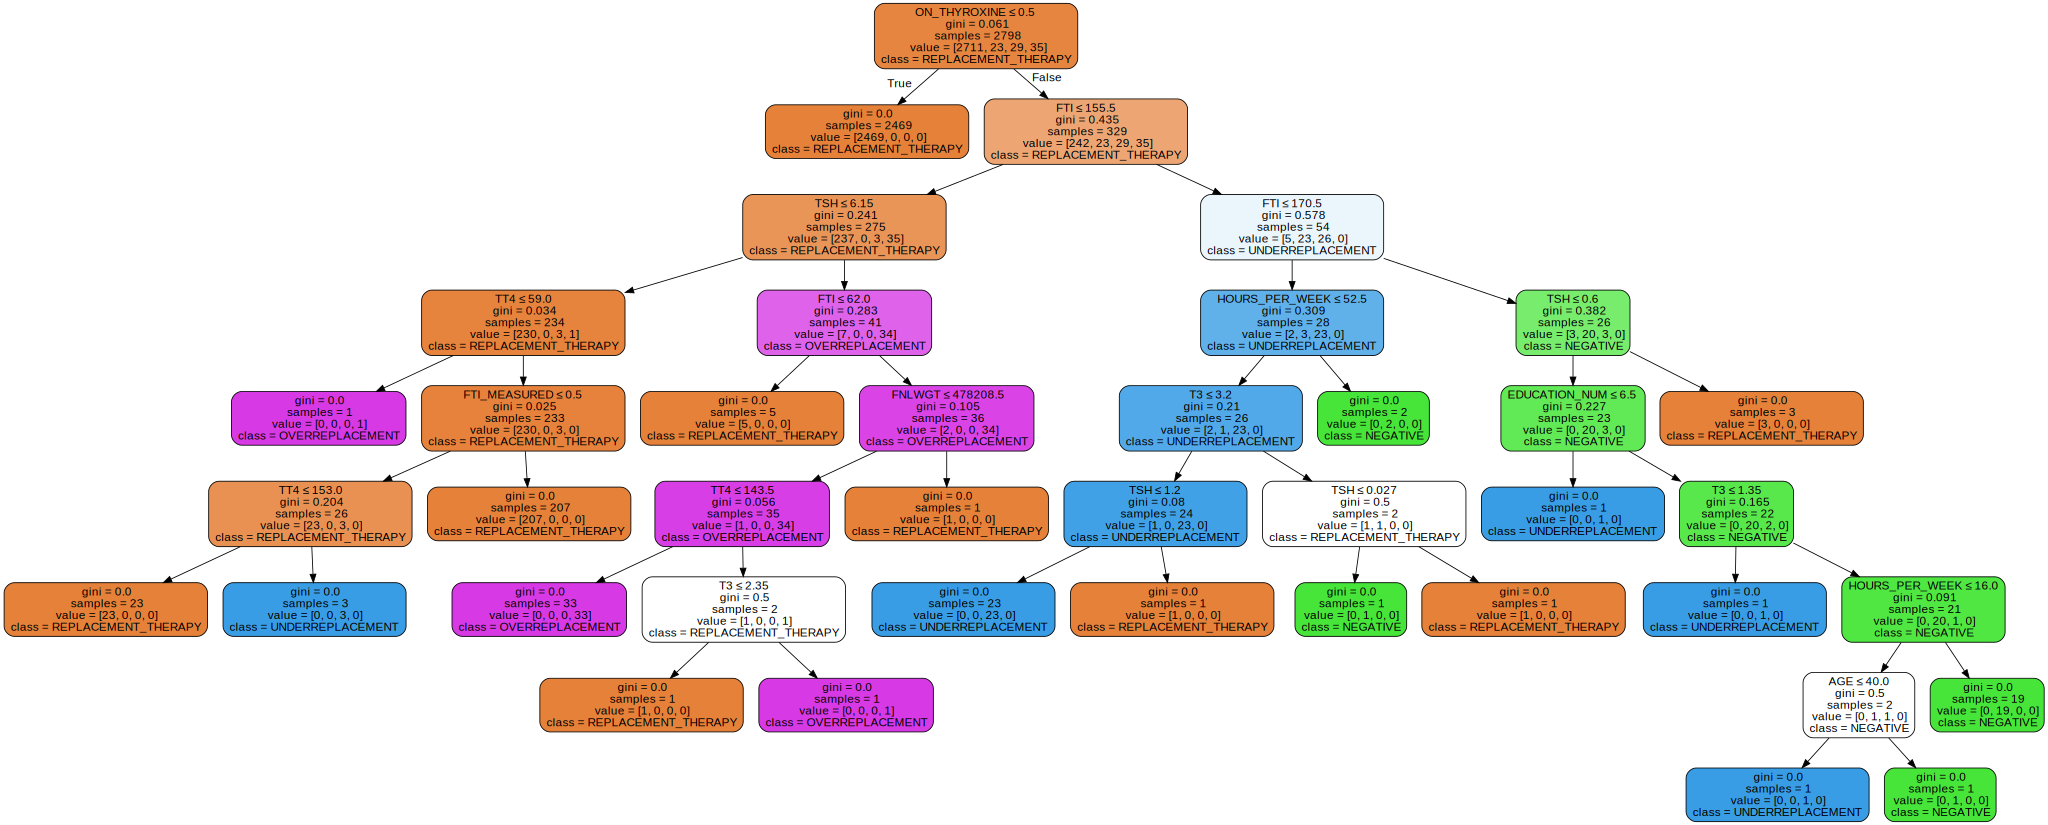

In [73]:
# Visualize data
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=train_X.columns,  
                         class_names=train_y.unique(),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("img/tree") 
graph